In [1]:
# import python libraries
import pandas as pd
import numpy as np

#import created functions
from explore import explore_data
from measure import two_sample_ttest, chi_test
import visualize as viz

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end


---
Preparatory Work
===

Using functions defined in `.py` modules, we can prepare a dataframe from a SQL query to the Codeup database server and output a DataFrame with the subset of data to be used in training of prediction models.

---


In [2]:
# acquire and assign dataset into pandas DataFrame
# this function will acquire, cache, prepare, and split dataset
df = explore_data()



             Data Processing Complete
    +----------------------------------------+
    |   Source DataFrame Shape : 7043 x 27   |
    |   Subset DataFrame Shape : 4225 x 27   |
    |     Data Percentage Used : 59.99%      |
    +----------------------------------------+   
        


In [3]:
# inspect shape of DataFrame to confirm with results of function
df.shape


(4225, 27)

In [4]:
# verify all dtypes for each series in the DataFrame as an appropriate type
# confirm all columns hold values for each row, no missing data
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 5135 to 6339
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   is_female          4225 non-null   int64  
 1   is_senior          4225 non-null   int64  
 2   has_partner        4225 non-null   int64  
 3   has_dependent      4225 non-null   int64  
 4   has_phone          4225 non-null   int64  
 5   one_line           4225 non-null   int64  
 6   multiple_lines     4225 non-null   int64  
 7   has_internet       4225 non-null   int64  
 8   dsl                4225 non-null   int64  
 9   fiber              4225 non-null   int64  
 10  streaming_tv       4225 non-null   int64  
 11  streaming_movies   4225 non-null   int64  
 12  online_security    4225 non-null   int64  
 13  online_backup      4225 non-null   int64  
 14  device_protection  4225 non-null   int64  
 15  tech_support       4225 non-null   int64  
 16  monthly_charges    42

In [5]:
# inspect first three rows of dataframe, tranposed for ease of reading
df.head(3).T


,5135,3213,4757
is_female,0.00,0.00,1.00
is_senior,0.00,1.00,0.00
has_partner,0.00,1.00,0.00
has_dependent,0.00,0.00,0.00
has_phone,1.00,1.00,1.00
one_line,1.00,0.00,1.00
multiple_lines,0.00,1.00,0.00
has_internet,1.00,1.00,1.00
dsl,0.00,0.00,0.00
fiber,1.00,1.00,1.00


---

# Data Exploration

Using the `train` dataset with stratification using `churn`, we begin the data exploration to find drivers of churn.

---

#### Initial Thoughts

- What role does customer tenure play?
  - Is there a range of tenure where clusters of churn form?
  - Are most customers who churn less than a year into service?
- Does a high monthly service charge affect churn?
  - Is there a resistance in charges where after breakthrough customers are more likely to churn?
- Are certain demographics and household makeups more or less likely to churn?

### Customer Distribution

Let's visualize the distribution for each variable among the sample. Here we will see the count of customers for each variable with `hue='churn'` to clearly show which has the more relative churned customers.

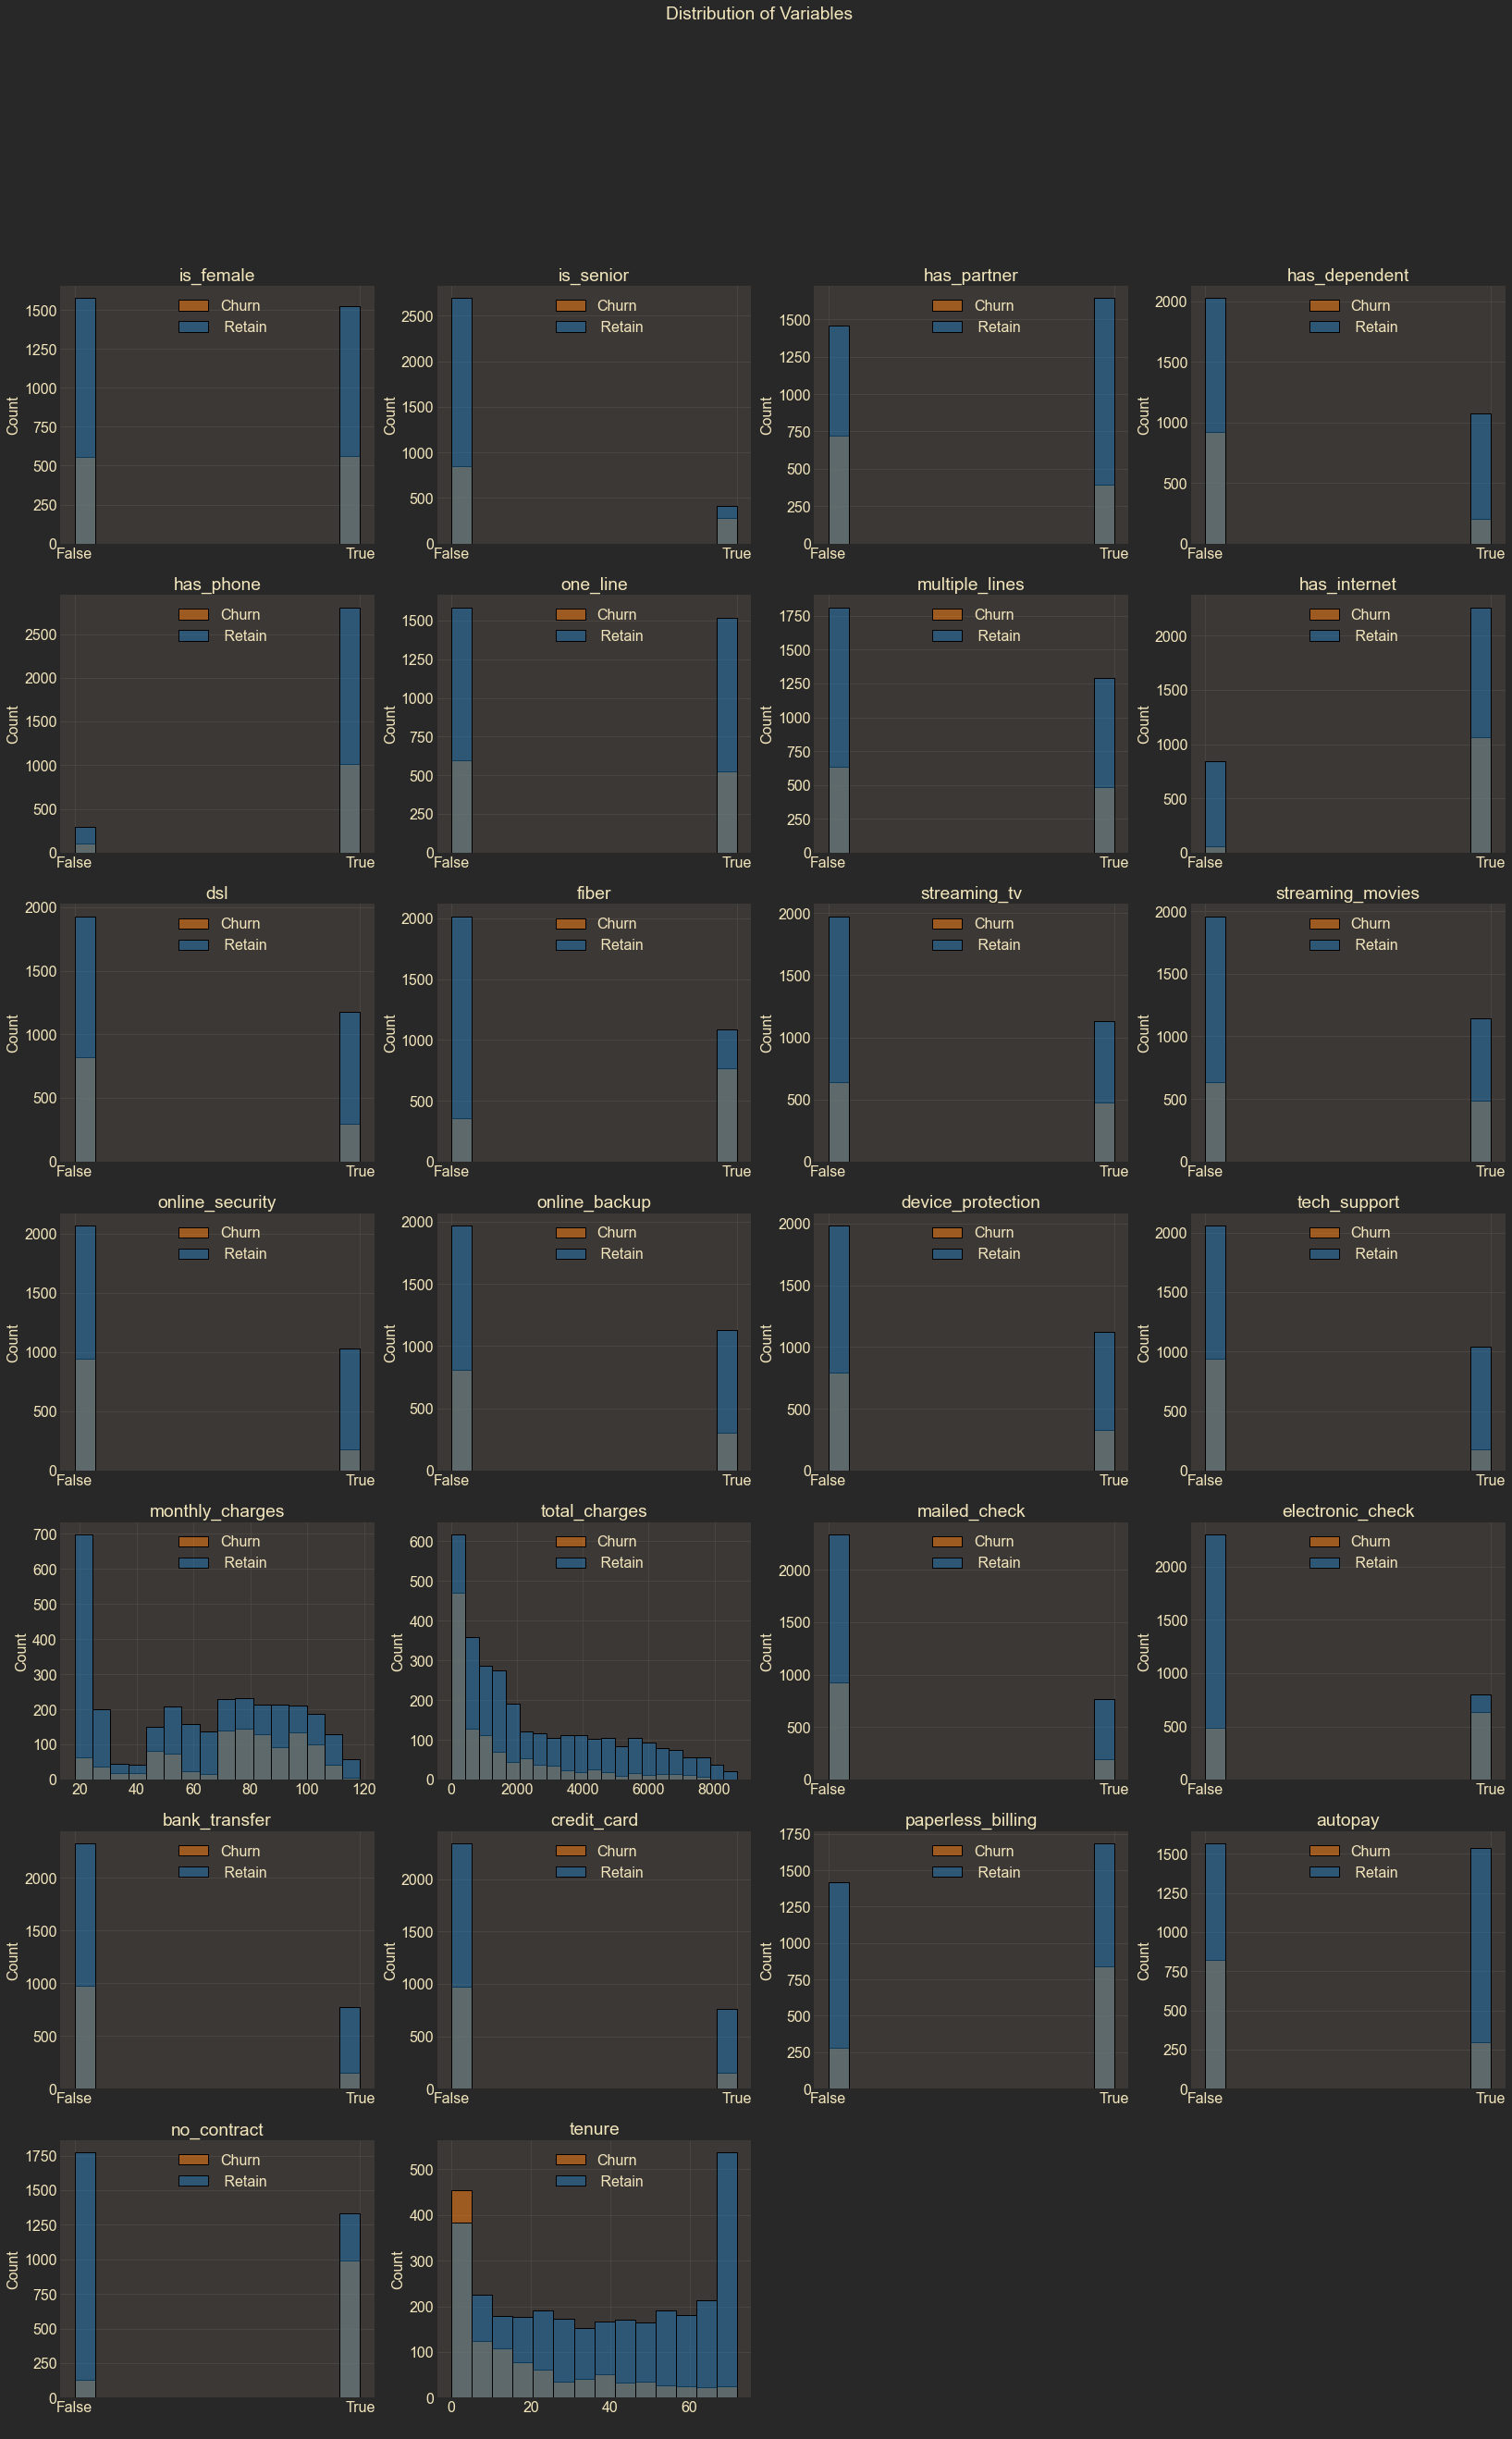

In [6]:
viz.hist_vars(df)


#### Distribution Breakdown

We can already see some answers to our questions. As customer `tenure` increase, the incidence of `churn` decreases. In the first year of service, there is signifcant more incidence of churn than in the following length of time. Length of service seems to have a definite impact on whether a customer will stay. Perhaps this is due to satisfaction with service, or maybe customer willingness to undertake the process of finding a new provider increases over time.

We can also see a generalize increased rate of `churn` in `monthly_charges` at and around the $80$ USD mark. Is this perhaps related to a particular set of services that falls within that range? We will need to look at this more in-depth. From here, we will inspect customers in the first year of service.

In [7]:
# split data into first and post years customers
first_year = df[df.tenure <= 12]
post_year = df[df.tenure > 12]


### Heatmap of First Year Customers

Now let's look at some statistical evaluation of all variables for first year customers as they relate to eachother.

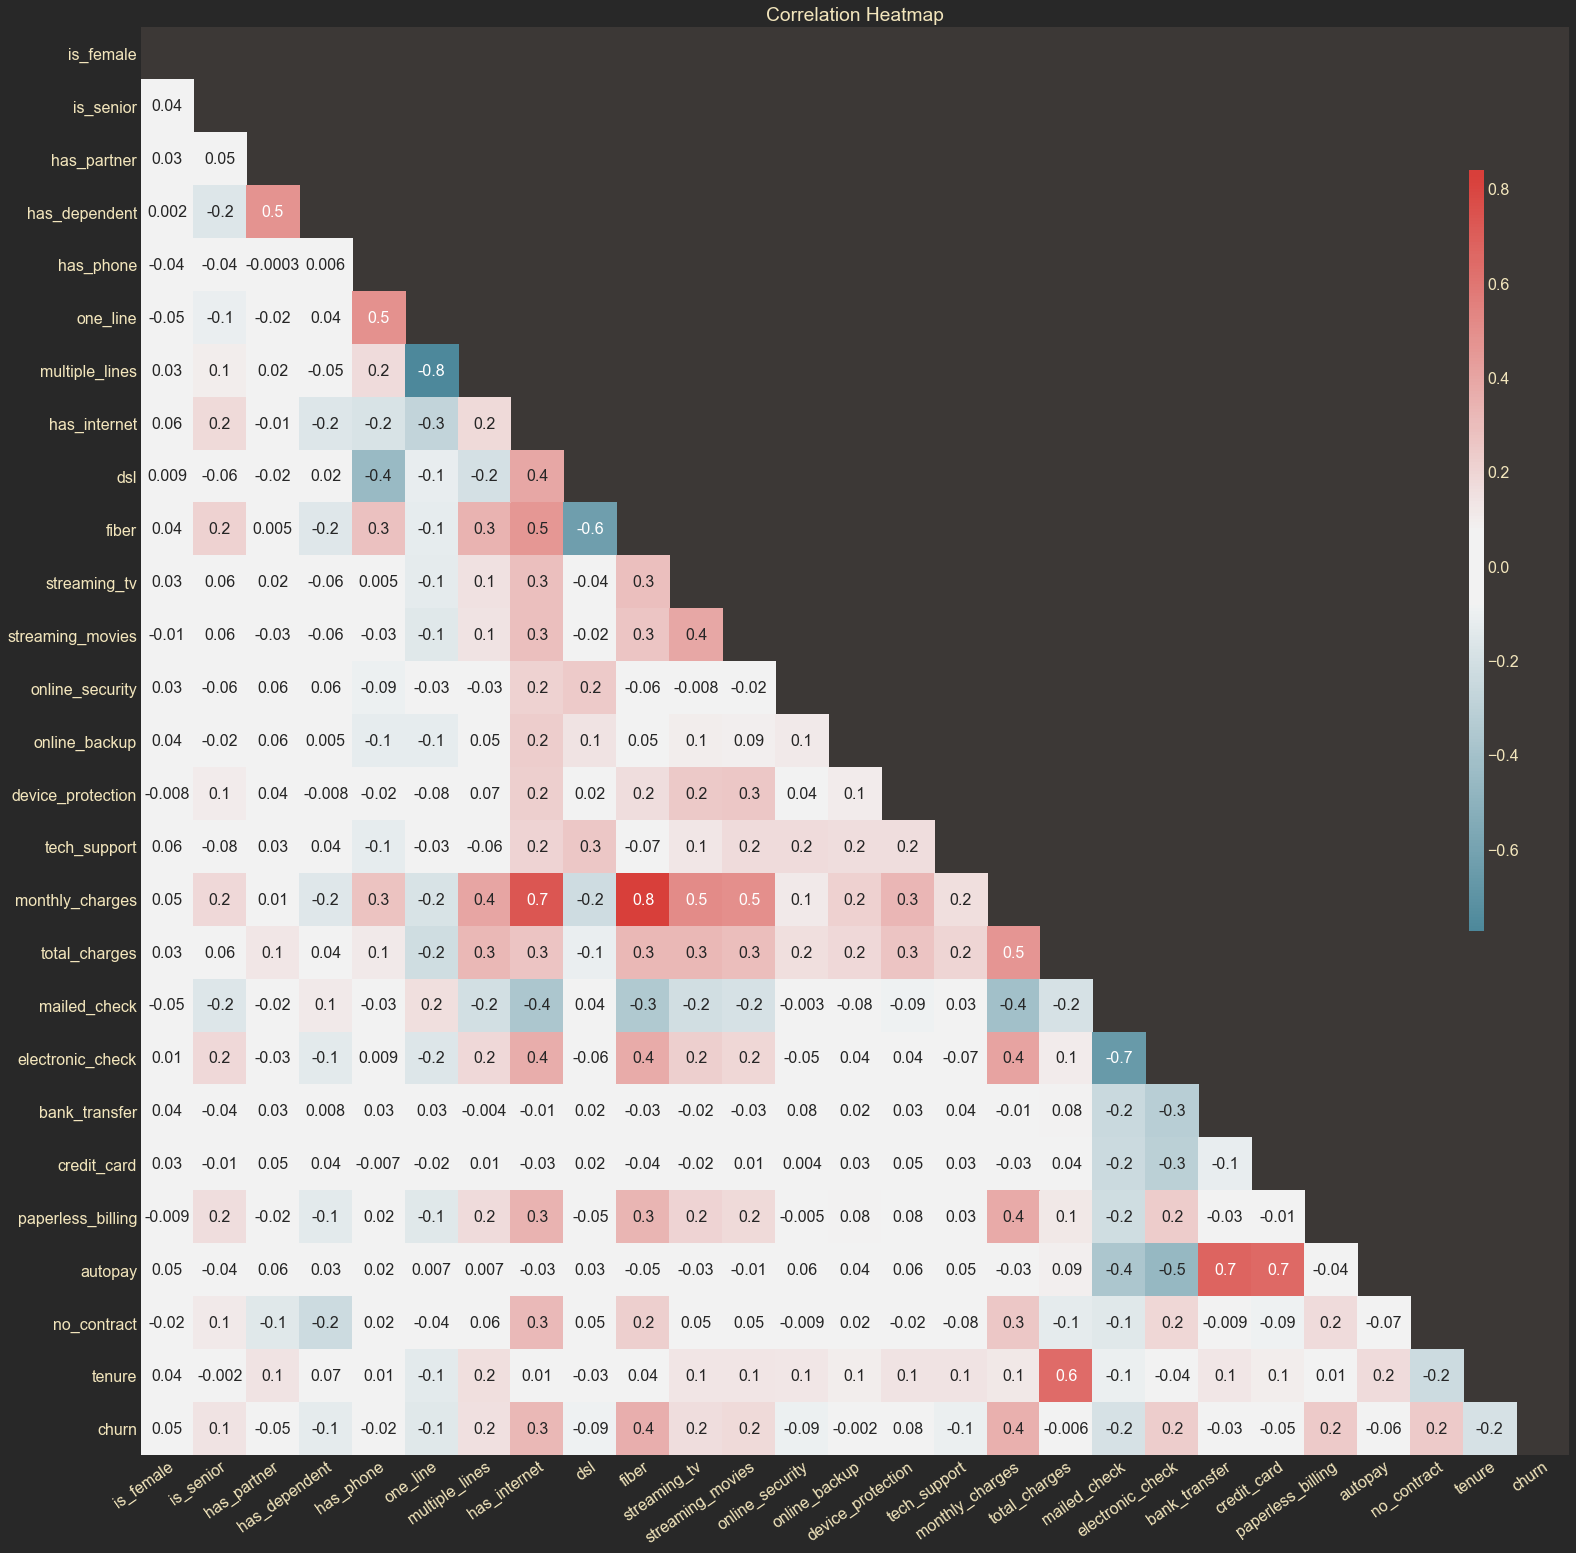

In [8]:
viz.big_heat(first_year)


#### Heatmap Breakdown

Here we see the corrrelation between each individual variable with darker reds indicating stronger positive relationships and darker blues indicating stronger negative relationships. 

There exist several unsurprisingly strong correlations such `tenure` and `total_charges`. We see a moderate positive relationship between `churn` and `monthly_charges`, as well as a strong positive relationship between `monthly_charges` and `fiber`. Perhaps there is play between the cost of fiber optic service and customer churn?

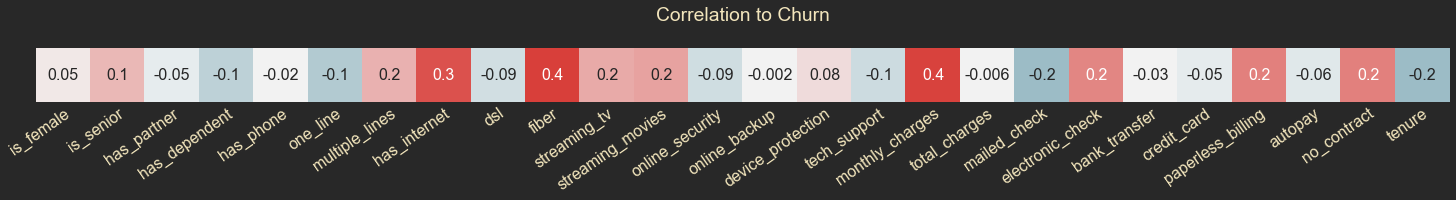

In [9]:
viz.heater(first_year)


When looking specifically at the relations to `churn`, our target variable, we see one of the strongest negative correlations is with `tenure` ($\approx-0.2$). It seems likely those who have been customers for longer periods of time are less inclined to leave, as well as customers under contract due to possible penalties associated with early termination.

The strongest positive correlations are with `fiber` ($\approx0.4$) and `monthly_charges` ($\approx0.4$). Much like when looking at the heatmap for all variables, we again see we should inspect these closer and see their relationships to eachother with regard to `churn`. There is also a moderately strong positive relationship with `electronic_check`. Is it possible there is an inconvenience related to using that payment method?

### Violin Plot of Internet Customers

Since we saw the high rate of churn in those first year customers, we are going to look at those customers using Telco as an internet service provider. Below we will compare monthly charges of DSL and fiber optic customers with retained customers side-by-side with churned customers.

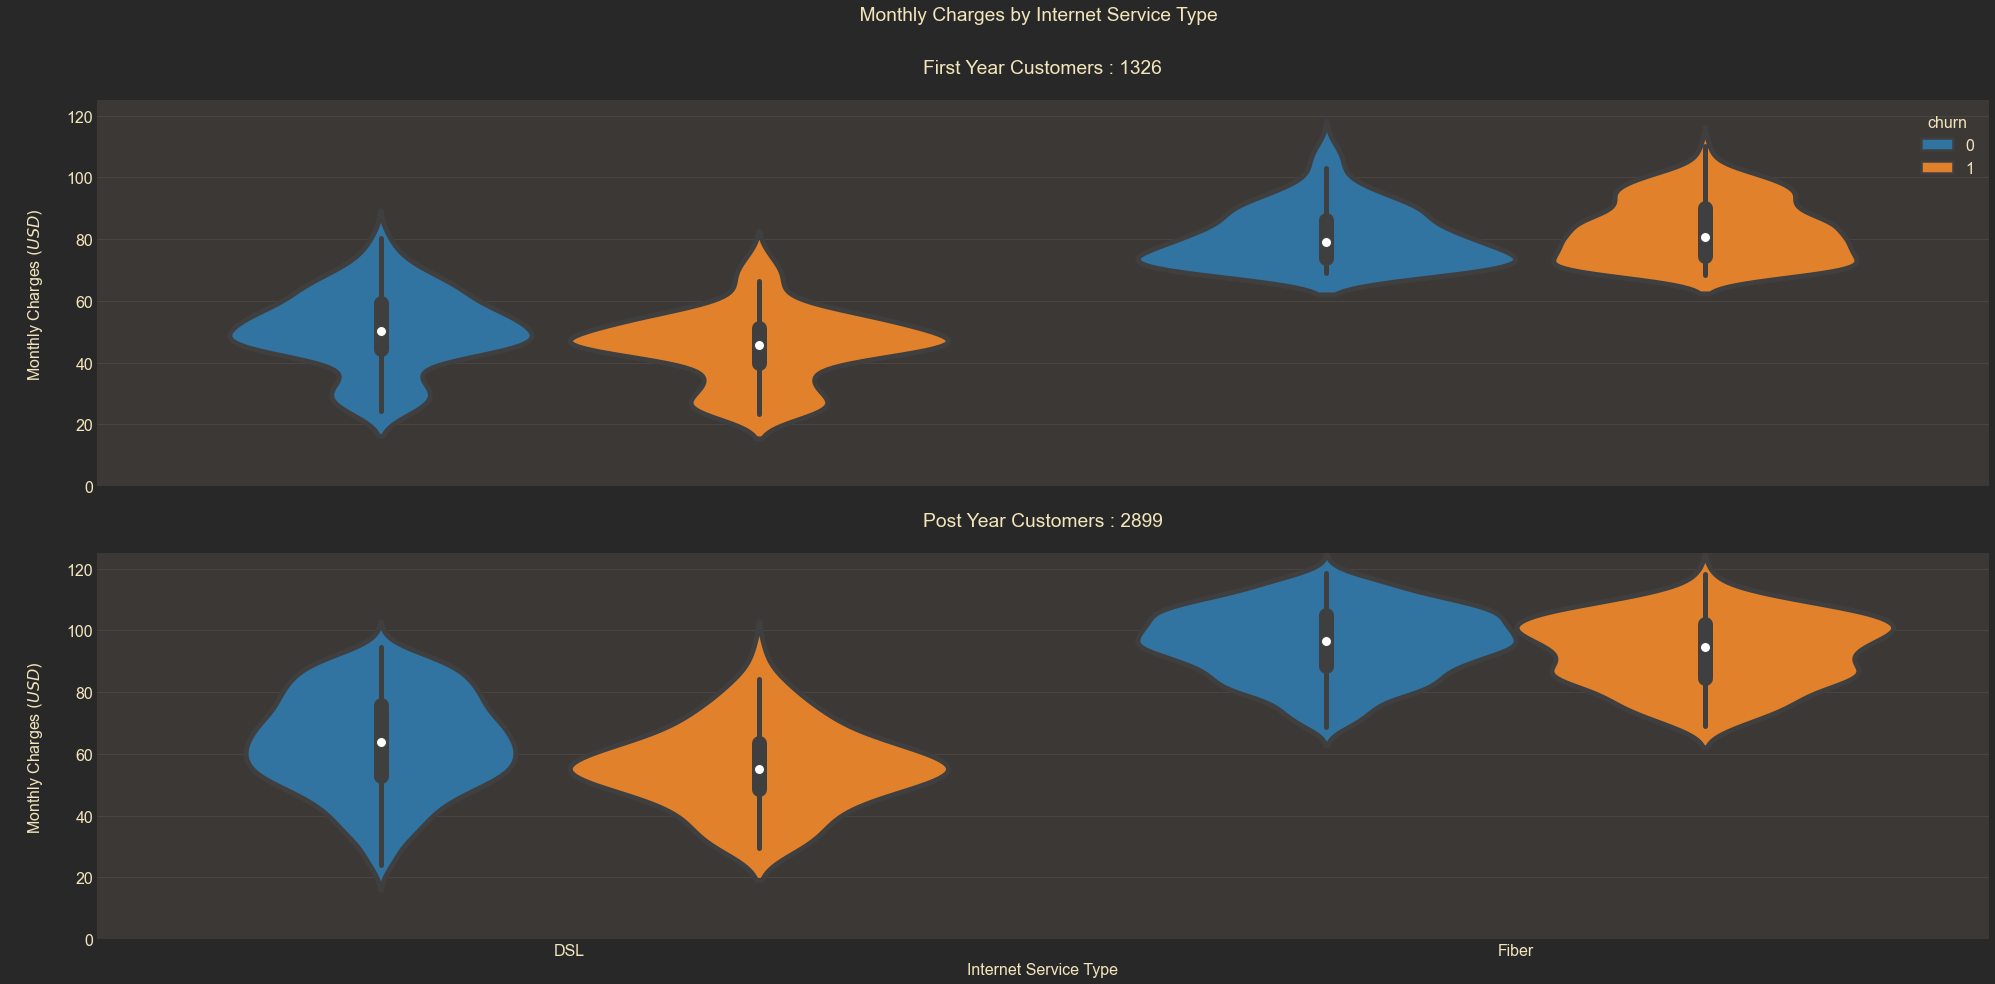

In [10]:
viz.internet_violin(df)


#### Violin Plot Breakdown

Looking purely at the visual, fiber customers who churned seem to pay similar prices as customers who are retained, both before and after their first year. Perhaps price doesn't have a particular part to play in churn.

In [11]:
viz.internet_breakdown(df)



         Total Fiber Customers: 1851
+ ------------------------------------------ +
|                                            |
|   First Year Fiber Customers: 559          |
|                                            |
|                      Churned: 385          |
|                      Percent: 68.87%       |
|                                            |
|    Post Year Fiber Customers: 1292         |
|                                            |
|                      Churned: 379          |
|                      Percent: 29.33%       |
|                                            |
+ ------------------------------------------ +



Looking at the relative numbers for service type and first-year/post-year comparisons, we see a huge percentage point difference between the two. First year fiber customers churned at a rate of $\approx69\%$! That is more than forty percentage points higher than post year cutomers. Let's look closer at first year fiber customers from here.

### T-Test of Monthly Charges

Let's do a statistical test to compare monthly charges of first year fiber customers who churned against those who are retained. We saw the visual output where things appeared similar, but a statistical test can answer questions better than our eyes at times. We will use a one-sided, two-sample `ttest_ind` from the `scipy.stats` module where the following three assumptions are true:

* [x] Data is approximately normally distibuted
* [x] Variances between two populations is equal
* [x] The two samples are independent

We will formulate our null and alternative hypotheses:

* H$_0$: Fiber customers who churn in the first year do not pay more than those who are retained.
* H$_a$: Fiber customers who churn in the first year pay more than those who are retained.

And define our `alpha`, or significance level:

* $\alpha$: 0.05

In [12]:
# define our a and b variables for ttest comparison
ab = df[(df.fiber == 1) & (df.tenure <= 12)]
a = ab[ab.churn == 1].monthly_charges
b = ab[ab.churn == 0].monthly_charges


In [13]:
# run two_sample_ttest function for one-tail
two_sample_ttest(a, b, alternative='greater')



  alpha: 0.05
p-value: 0.009

        Due to our p-value of 0.009 being less than our significance level of 0.05, we must reject the null hypothesis
        that there is no difference in monthly_charges between the two populations.
        


#### Takeaway

We reject our null hypothesis. There is evidence that fiber customers who churn do pay more than those who do not. That leaves us in a position to begin modeling. But first, let's see one more thing that will lead us to finding a better resolution. How many customers who churn are on contract terms and how many are not.

In [14]:
viz.internet_contract_compare(df)



        Fiber Customer Comparisons
+----------------------------------------+
|                                        |
|     First Year Customers: 559          |
|                                        |
|                  Churned: 385          |
|             Mean Charges: $82.73       |
|           Under Contract: 0.52%        |
|                                        |
|                 Retained: 174          |
|             Mean Charges: $80.59       |
|         Under Contracted: 2.30%        |
|                                        |
|      Post Year Customers: 1292         |
|                                        |
|                  Churned: 379          |
|             Mean Charges: $93.13       |
|           Under Contract: 19.79%       |
|                                        |
|                 Retained: 913          |
|             Mean Charges: $95.98       |
|         Under Contracted: 54.33%       |
|                                        |
|     Total Under 

This table shows us that contracts are being under utilized. Less than $2\%$ of first year customers are under a contract, either two- or one-year. It is outside the realm of possibility to offer month-to-month terms and expect all customers to choose to opt for a contractual obligation; however, it is not unreasonable to expect those numbers to be higher than $2\%$.

We also see that mean charges are higher in retained post-year customers, whereas mean charges were higher in churned first-year customers. This just drives further the strength of contracts to help get customers to their service anniversary.

### $\chi^2$ Test of Categorical Variables

Now that we've looked at our continuous variable, let's look at the categorical variables we've been working with and perform a $\chi^2$ statistical test and compare them to churn. Here we will be inputting a DataFrame that contains our observed data between our category for comparison and our categorical target.

We again formulate our null and alternative hypotheses as automated by the function:
- H$_0$: Churn is independent of the compared category.
- H$_a$: Churn is not independent of the compared category.


In [15]:
# set list of categorical features for chi_square test
v_cats = ['has_internet', 'fiber', 'electronic_check', 'no_contract']


In [16]:
# loop chi_square through features chosen for model stage
# to determine whether to accept or reject null hypotheses
for cat in v_cats:
    chi_test(df[cat], df.churn)



  alpha: 0.05
p-value: 4e-52

        Due to our p-value of 4e-52 being less than our significance level of 0.05, we must reject the null hypothesis
        that churn is independent of has_internet.

                       ** Observed **                        |       ** Expected **
                       --------------------------------------|--------------------------------------
                                     No Churn    Churn       |                     No Churn    Churn
                                                             |       
                       No Fiber      841         60          |       No Fiber      662         239       
                                                             |       
                          Fiber      2263        1061        |          Fiber      2442        882       
    

  alpha: 0.05
p-value: 1e-81

        Due to our p-value of 1e-81 being less than our significance level of 0.05, we must reject the null hypothesis
     

With low p-values across the board, we can see that we reject the null hypothesis that any of these variables are independent of our target. This suggests that they are good candidates for features in our modeling phase.

---
Summation
===

It is possible to explore and analyze this data until the heat death of the universe, but we have acquired a direction to move into the next steps. From here we will move into modeling predictions with the features we explored here.

---

#### Final Takeaways

- Tenure plays a strong role in churn
- Getting customers past the first year significant reduces churn
- Utilizing contracts improves likelihood of getting customer to first service anniversary
- Monthly charges are greater in churned first year customers than retained first year
- Monthly charges are great in retained post year customer than churned post year
- All of our categorical features $\chi^2$ tests rejected the null hypothesis

In [17]:
end()


































 

































 

































 Believe in the me that believes in you!
